# 6 урок: Многорукие бандиты

In [1]:
from IPython.display import Image, Math
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from typing import Dict, List, Tuple, Any, Union

# Для симуляции среды
from scipy.optimize import fsolve

# Для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Для логгирования
import logging
logging.basicConfig()
logger = logging.getLogger("model")
logger.setLevel(logging.INFO)

# Подходы использования многоруких бандитов
- <b>в классическом понимании</b>
- <b>в качестве модели спроса</b>
- для распределения трафика в АБ

# Что будем делать?

- рассмотрим, как можно использовать многоруких бандитов в классическом понимании
    - имплементируем стратегии многоруких бандитов
    - сделаем симуляцию среды для динамического ценообразования
    - выберем лучшую стратегию для решения поставленной задачи
- рассмотрим, как можно использовать многоруких бандитов в качестве модели спроса
    - обсудим, в какой момент можно перейти от exploration к exploitation 
    - поймем, как применять ограничения от бизнеса, когда используются многорукие бандиты

# Задача

Ваша задача - сделать алгоритм динамического ценообразования на основе многоруких бандитов так, чтобы максимизировать выручку товара*:

<center>$Revenue \rightarrow \max$</center>
<center>$Revenue = price * quantity$</center>

\* В реальности мы всегда ценообразуем пул товаров, но для простоты объяснения возьмем один товар для ценообразования. Если нужно применить бандитов для нескольких товаров, то можно сделать на каждый товар своего многорукого бандита.

# Многорукие бандиты в классическом понимании

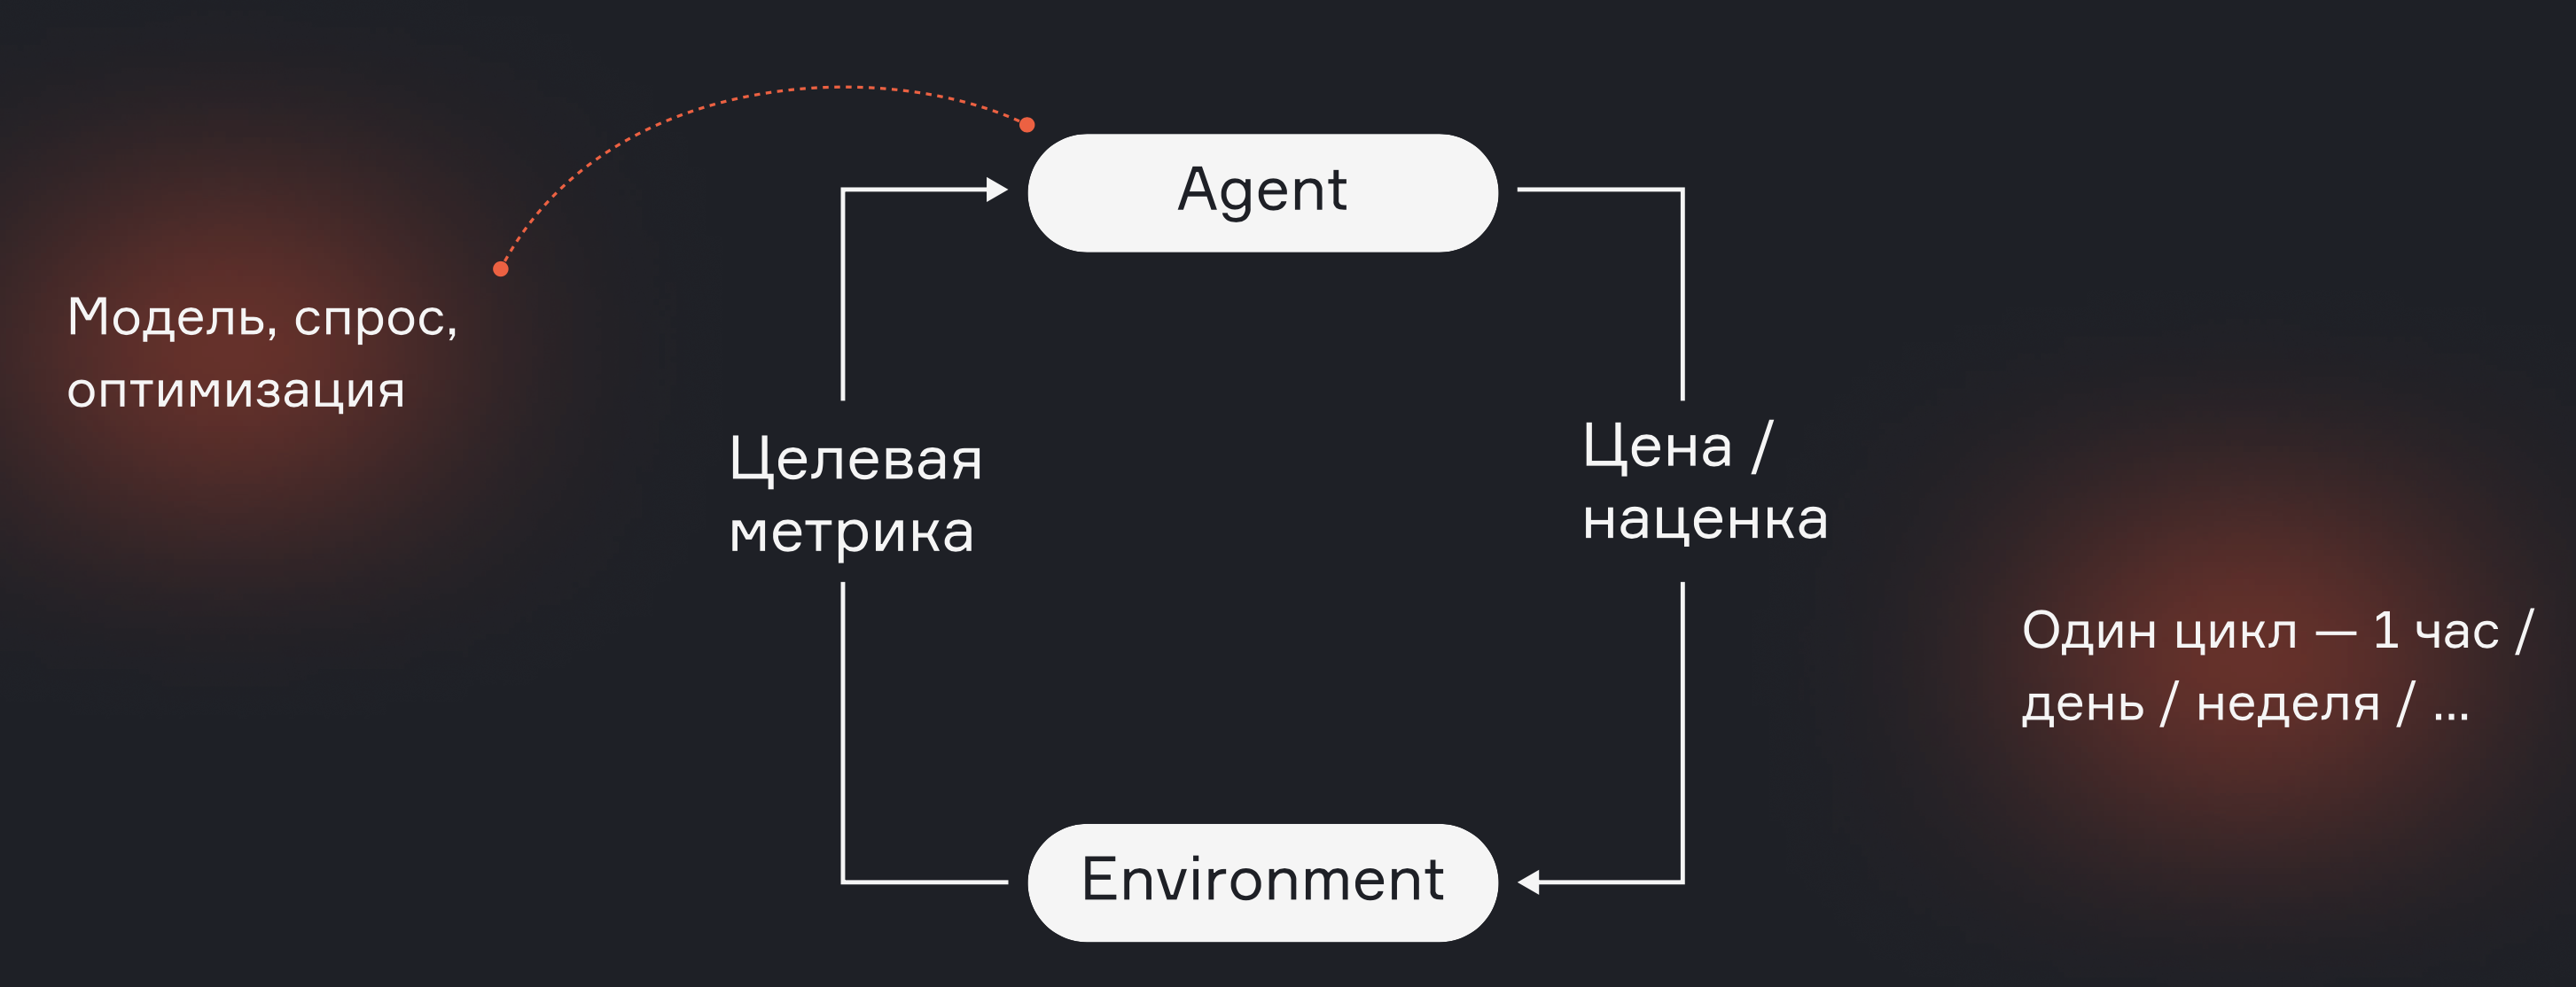

In [2]:
Image("./images/classic_mab.png", width=1000, height=400)

Перед тем, как запустить многоруких бандитов в продакшене, их следует проверить в офлайне. Для этого мы проведем симуляцию работы многоруких бандитов, чтобы выбрать лучшую стратегию для максимизации выручки товара.

## Agent

Стратегии:
- ε-greedy
- UCB (upper confidence bound)
- Thompson sampling

Давайте заимплементируем 2 первых стратегии

In [3]:
class Strategy:
    def __init__(self, n_arms: int):
        """
        Инициализация базовой стратегии.
        
        Параметры:
        - n_arms (int): Количество доступных ручек (опций) для выбора.
        
        Атрибуты:
        - n_arms (int): Хранит количество ручек.
        - n_iters (int): Счетчик количества сделанных выборов (итераций).
        - arms_states (dict): Словарь, хранящий массивы с суммарными значениями различных метрик (например, 
                              количество, выручка, маржа), полученными от каждой ручки.
        - arms_actions (np.array): Массив, хранящий количество выборов каждой ручки.
        """
        self.n_arms = n_arms
        self.n_iters = 0
        self.arms_states = {
            "quantity": np.zeros(n_arms),
            "revenue": np.zeros(n_arms),
            "margin": np.zeros(n_arms),
        }
        self.arms_actions = np.zeros(n_arms)  # Количество действий для каждой ручки
    
    def flush(self):
        """
        Сброс состояния стратегии.
        
        Обнуляет счетчик итераций и массивы состояний и действий ручек,
        что позволяет начать процесс выбора заново без потери информации о количестве ручек.
        """
        self.n_iters = 0
        for metric in self.arms_states.keys():
            self.arms_states[metric] = np.zeros(self.n_arms)
        self.arms_actions = np.zeros(self.n_arms)
        
    def update_reward(self, arm_id: int, metrics: Dict[str, float]):
        """
        Обновляет информацию о метриках и выборах для указанной ручки.
        
        Параметры:
        - arm_id (int): Индекс ручки, для которой обновляется информация.
        - metrics (Dict[str, float]): Словарь с метриками (например, количество, выручка, маржа),
                                      полученными за выбор данной ручки.
        
        При вызове увеличивает количество итераций, обновляет суммарные значения указанных метрик
        и учет количества выборов для указанной ручки.
        """
        self.n_iters += 1
        for metric, value in metrics.items():
            self.arms_states[metric][arm_id] += value
        self.arms_actions[arm_id] += 1  # Увеличиваем счетчик действий для ручки
        
    def choose_arm(self):
        """
        Абстрактный метод выбора ручки.
        
        Должен быть реализован в подклассах, определяя специфическую логику выбора ручки.
        
        Выбрасывает исключение, если вызывается напрямую, т.к. требует реализации в подклассе.
        """
        raise NotImplementedError("This method should be implemented by subclasses")


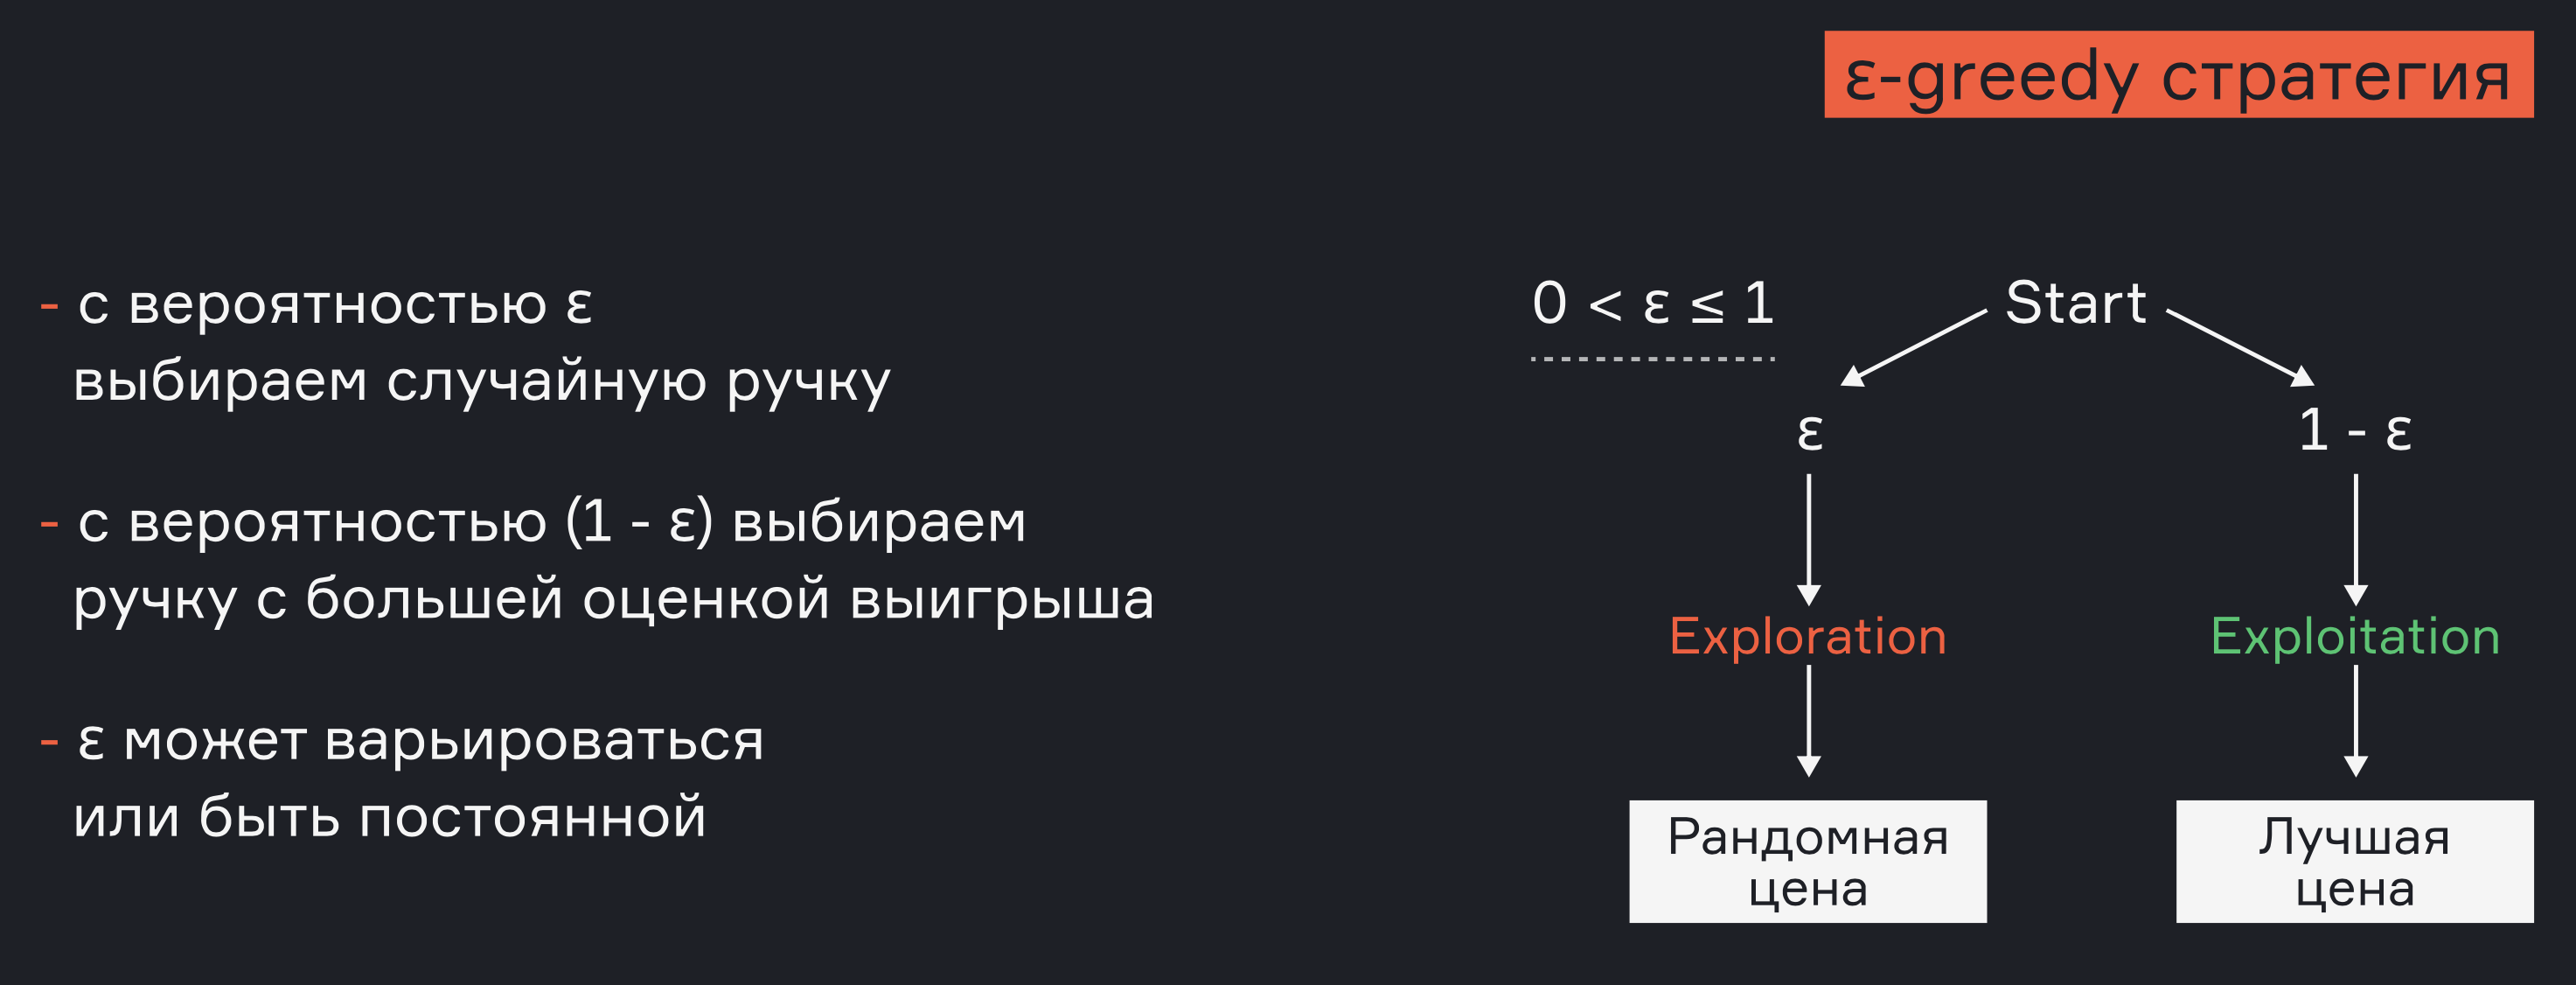

In [4]:
Image("./images/eps_greedy.png", width=1000, height=400)

In [5]:
class EpsGreedy(Strategy):
    def __init__(self, n_arms: int, eps: float = 0.1):
        """
        Инициализация ε-жадной стратегии.
        
        Параметры:
        - n_arms (int): Количество доступных опций для выбора.
        - eps (float): Вероятность исследования, где 0 <= eps <= 1. С вероятностью eps
                       алгоритм выбирает случайную опцию, а с вероятностью 1 - eps — опцию
                       с максимальным средним вознаграждением.
        """
        super().__init__(n_arms)
        self.eps = eps
        
    def choose_arm(self, target: str) -> int:
        """
        Выбор опции с учетом стратегии ε-жадности.
        
        С вероятностью eps происходит случайный выбор опции. В противном случае выбирается
        опция с максимальным средним вознаграждением.
        
        Возвращает:
        - int: Индекс выбранной опции.
        """
        # Случайный выбор с вероятностью eps
        if random.random() < self.eps:
            return random.randint(0, self.n_arms - 1)
        else:
            # Вычисление средних вознаграждений для каждой опции
            arm_rewards = self.arms_states[target] / (self.arms_actions + 1e-5)  # Предотвращение деления на ноль
            # Выбор опции с максимальным средним вознаграждением
            return np.argmax(arm_rewards)

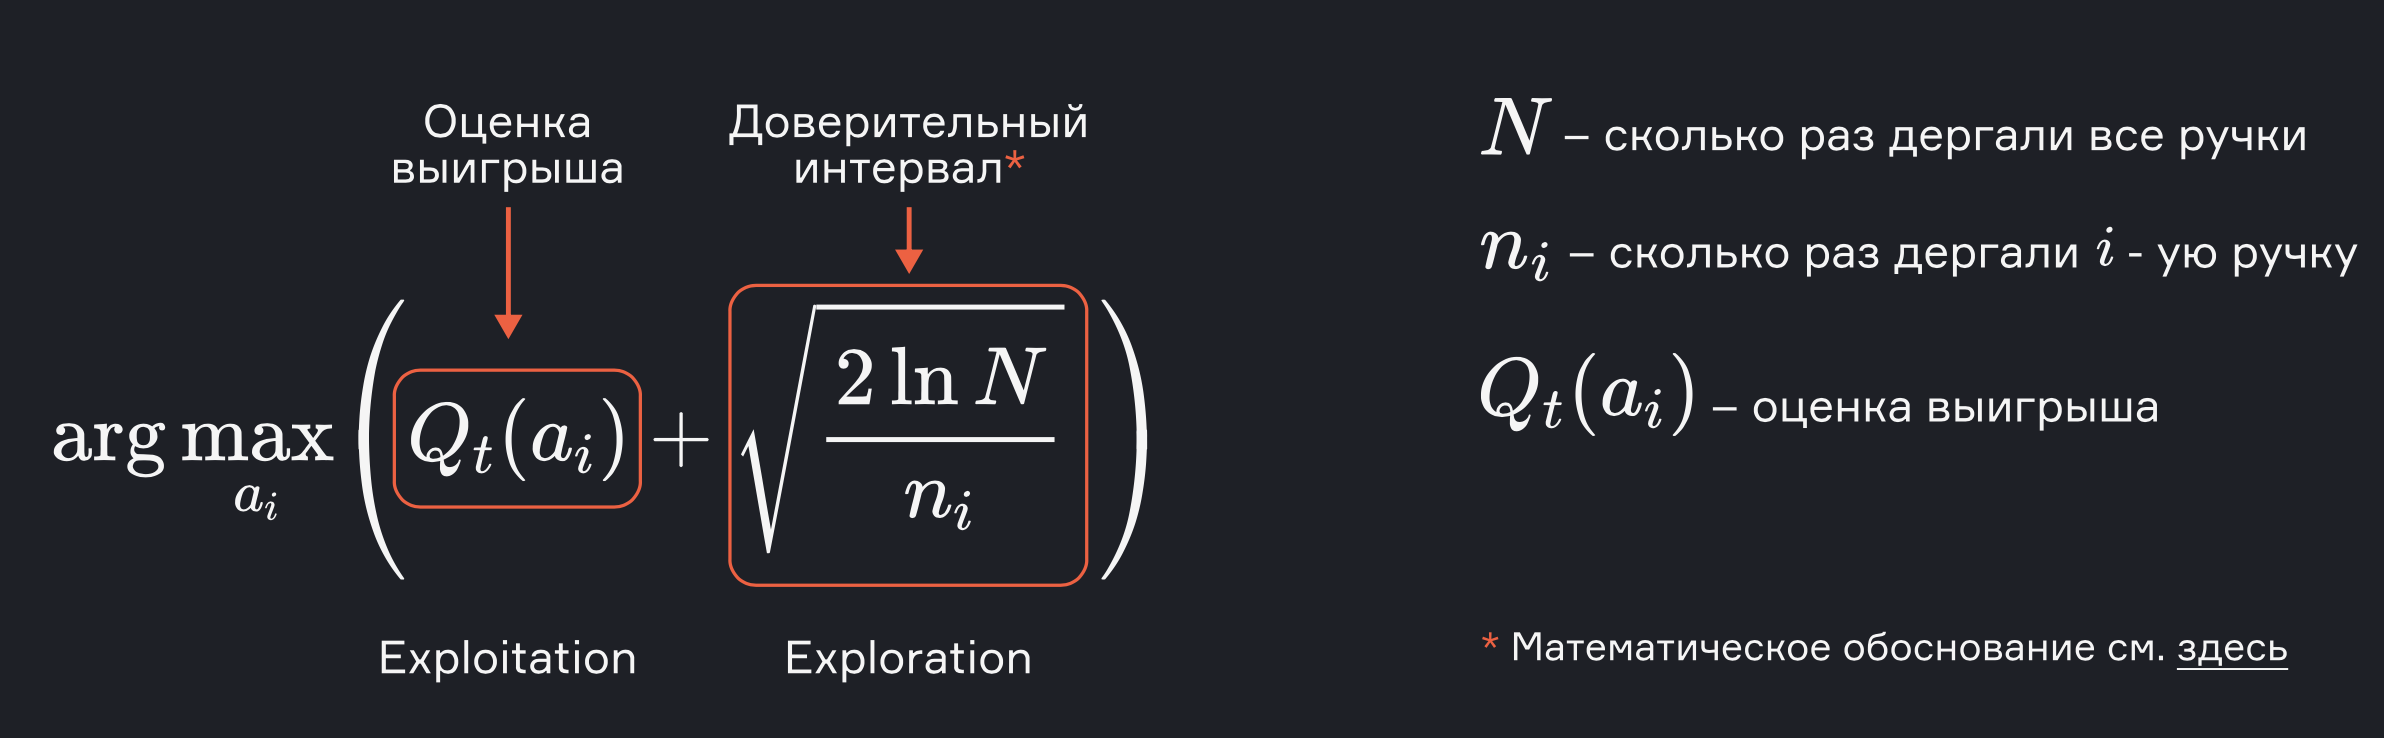

In [6]:
Image("./images/ucb.png", width=1000, height=400)

In [7]:
class UCB1(Strategy):
    def choose_arm(self, target: str) -> int:
        """
        Выбирает опцию (руку) для следующего действия.
        
        На начальной стадии, когда количество итераций меньше количества опций, 
        выбор идет последовательно для каждой опции, чтобы гарантировать, 
        что каждая опция будет выбрана хотя бы один раз.
        
        После этого выбор осуществляется на основе значения верхней границы доверительного интервала (UCB).
        
        Возвращает:
        - int: Индекс выбранной опции.
        """
        # Если количество итераций меньше количества опций,
        # выбираем опции последовательно для инициализации
        if self.n_iters < self.n_arms:
            return self.n_iters
        else:
            # Иначе выбираем опцию с максимальным значением UCB
            return self.ucb(target=target)
        
    def ucb(self, target: str) -> int:
        """
        Рассчитывает и возвращает индекс опции с максимальным значением UCB.
        
        UCB для каждой опции вычисляется как сумма среднего вознаграждения по опции
        и части уверенности, основанной на количестве сыгранных раундов и количестве
        выборов каждой опции.
        
        Возвращает:
        - int: Индекс опции с максимальным значением UCB.
        """
        # Рассчитываем общее количество сыгранных раундов
        total_plays = self.n_iters + 1
        # Вычисляем значения UCB для каждой опции
        ucb_values = self.arms_states[target] / (self.arms_actions + 1e-5) + \
                     np.sqrt(2 * np.log(total_plays) / (self.arms_actions + 1e-5))
        # Возвращаем индекс опции с максимальным значением UCB
        return np.argmax(ucb_values)

## Environment

PriceEnv предоставляет возможность экспериментировать с различными ценовыми сценариями и стратегиями без риска для реального бизнеса.

In [8]:
class PriceEnv:
    def __init__(self, prices: List[float], cost: float, base_demand: float, elasticity: float):
        """
        Инициализация среды с заданным набором цен и параметрами для моделирования спроса.
        - prices (list): Список цен.
        - base_demand (float): Максимально возможный спрос при нулевой цене.
        - elasticity (float): Коэффициент, влияющий на чувствительность спроса к изменению цены.
        """
        self.prices = prices
        self.cost = cost
        self.base_demand = base_demand
        self.elasticity = elasticity

    @property
    def n_arms(self) -> int:
        """
        Возвращает количество доступных цен.
        - int: Количество опций.
        """
        return len(self.prices)

    def pull_arm(self, arm_id: int) -> float:
        """
        Возвращает вознаграждение за выбор определенной опции, основываясь на её цене.
        - arm_id (int): Индекс выбранной опции.
        """
        price = self.prices[arm_id]
        return self.get_reward(price=price)

    def quantity_curve(self, price: Union[np.ndarray, float]) -> Union[np.ndarray, float]:
        """
        Вычисляет спрос на основе заданной цены, используя логистическую функцию спроса.
        - price (np.ndarray | float): Цена или массив цен.
        """
        return self.base_demand / (1 + np.exp(self.elasticity * price))

    def get_reward(self, price: Union[np.ndarray, float]) -> Dict[str, Union[np.ndarray, float]]:
        """
        Рассчитывает количественные показатели на основе цены: количество, выручку и маржу.
        - price (np.ndarray | float): Цена или массив цен.
        """
        quantity = self.quantity_curve(price)
        # Предполагаем, что фактическое количество продаж может варьироваться вокруг ожидаемого значения
        # Для этого используем распределение Пуассона
        quantity = np.random.poisson(quantity)
        revenue = price * quantity
        margin = revenue - self.cost * quantity
        return {"quantity": quantity, "revenue": revenue, "margin": margin}

    def derivative(self, price: Union[np.ndarray, float], target: str) -> Union[np.ndarray, float]:
        """
        Вычисляет производную целевого показателя по цене.
        - price (np.ndarray | float): Цена или массив цен.
        - target (str): Целевой показатель ('revenue', 'margin', 'quantity').
        """
        quantity_derivative = -self.base_demand * self.elasticity * np.exp(self.elasticity * price) / ((np.exp(self.elasticity * price) + 1) ** 2)
        if target == 'revenue':
            return quantity_derivative * price + self.quantity_curve(price)
        elif target == 'margin':
            return quantity_derivative * (price - self.cost) + self.quantity_curve(price)
        elif target == 'quantity':
            return quantity_derivative
        else:
            raise ValueError("Unsupported target for derivative calculation")

    def get_optimal_price(self, target: str) -> Union[np.ndarray, float]:
        """
        Использует производную функции целевого показателя для нахождения оптимальной цены.
        - target (str): Целевой показатель для оптимизации ('revenue', 'margin', 'quantity').
        Для того чтобы найти максимум функции, необходимо найти точку, в которой её производная равна нулю.
        """
        return fsolve(self.derivative, 0, args=(target))[0]

Давайте проиллюстрируем на примере одного товара как выглядит у нас среда, а именно изобразим метрики quantity / revenue / margin

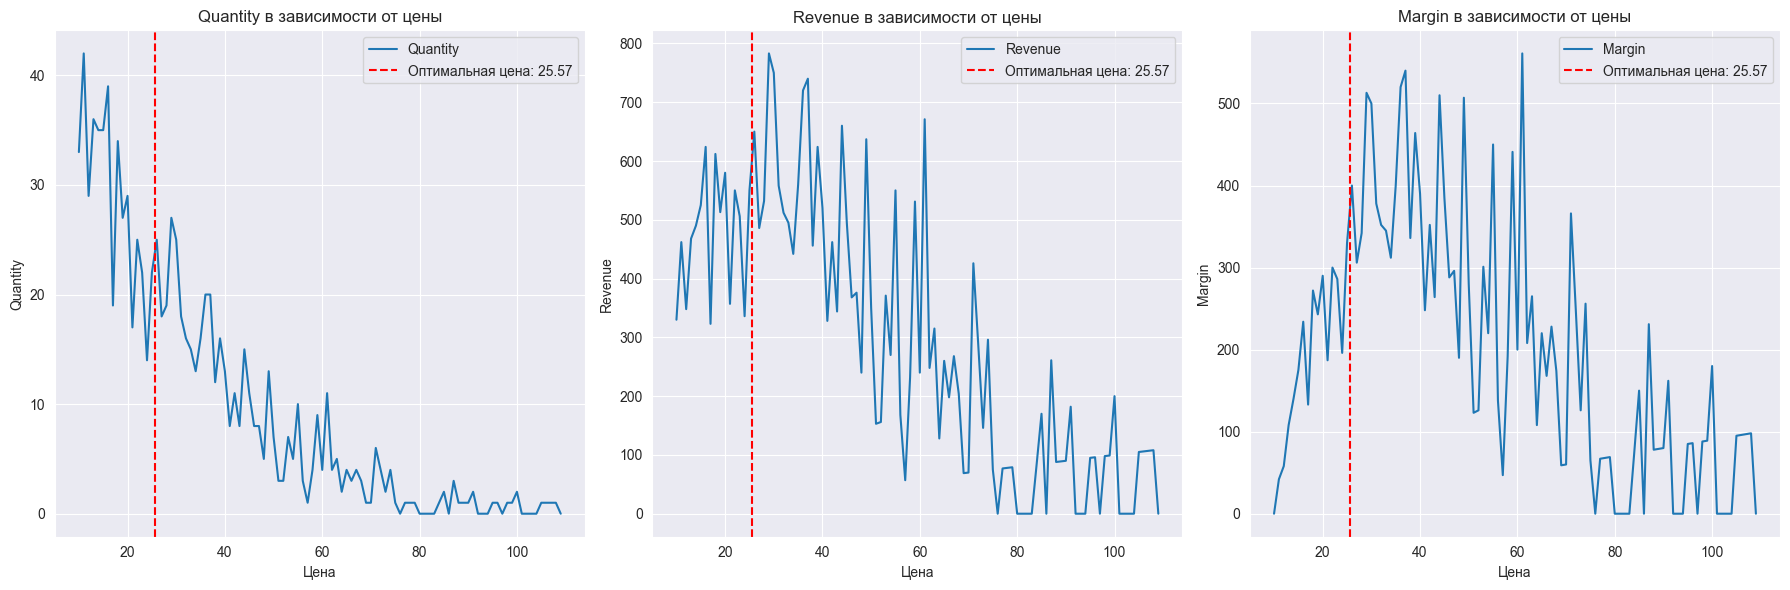

In [9]:
base_demand, elasticity = 100, 0.05
prices = np.arange(10, 110, 1).round(2)
cost = 10
target = "revenue"
env = PriceEnv(prices=prices, cost=cost, base_demand=base_demand, elasticity=elasticity)

# Расчет спроса, выручки и оптимальной цены
metrics_values = env.get_reward(price=prices)
optimal_price = env.get_optimal_price(target=target)

# Создание графиков
plt.figure(figsize=(18, 6))  # Увеличили размер для удобства восприятия

metrics = {
    "Quantity": {
        "id": 1,
    },
    "Revenue": {
        "id": 2,
    },
    "Margin": {
        "id": 3,
    },
}
for metric_name, plot_dict in metrics.items():
    plt.subplot(1, len(metrics), plot_dict["id"])
    plt.plot(prices, metrics_values[metric_name.lower()], label=metric_name)
    plt.axvline(x=optimal_price, color='r', linestyle='--', label=f'Оптимальная цена: {optimal_price:.2f}')
    plt.xlabel('Цена')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} в зависимости от цены')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

<font color="red">Оптимальная цена — это не та цена, при которой спрос (количество продаж) максимален, а та, при которой максимизируется выручка, учитывая соотношение между ценой и количеством продаж.</font>

## Симуляция

In [10]:
class Bandit:
    def __init__(self, env: PriceEnv, strategy: Strategy, target: str):
        """
        Инициализация экземпляра многорукого бандита.
        
        Параметры:
        - env (PriceEnv): Среда, содержащая информацию о ценах и спросе.
        - strategy (Strategy): Стратегия выбора ручки (опции).
        """
        self.env = env
        self.strategy = strategy
        self.target = target
        self.n_iters = 0
        self.cum_regret = 0
        self.cum_reward = 0
        self.optimal_price = env.get_optimal_price(target=target)
        self.optimal_reward = env.get_reward(price=self.optimal_price)[target]

    def action(self) -> None:
        """
        
        Выполнение одного действия выбора и обновления статистики.
        """

        # Select arm
        arm_id = self.strategy.choose_arm(target=self.target)

        # Set selected arm and get corresponding metrics
        metrics = self.env.pull_arm(arm_id=arm_id)

        # Update the metrics
        self.strategy.update_reward(arm_id=arm_id, metrics=metrics)

        # Register an iteration
        self.n_iters += 1

        # Calculate reward
        reward = metrics[self.target]

        # Рассчитываем и обновляем кумулятивную награду
        self.cum_reward += reward

        # Рассчитываем и обновляем кумулятивное сожаление
        self.cum_regret += self.optimal_reward - reward

    def plot_curves(self, step: int) -> None:
        mean_quantity = self.strategy.arms_states["quantity"] / self.strategy.arms_actions
        mean_revenue = self.strategy.arms_states["revenue"] / self.strategy.arms_actions
        mean_margin = self.strategy.arms_states["margin"] / self.strategy.arms_actions
        
        plt.figure(figsize=(20, 4))

        metric_dict = {
            "Средний Quantity": {
                "color": "blue",
                "id": 1,
                "values": mean_quantity,
            },
            "Средний Revenue": {
                "color": "green",
                "id": 2,
                "values": mean_revenue,
            },
            "Средний Margin": {
                "color": "black",
                "id": 3,
                "values": mean_margin,
            },
        }
        for metric_name, plot_dict in metric_dict.items():
            ax1 = plt.subplot(1, len(metric_dict.keys()), plot_dict["id"])
            ax1.plot(self.env.prices, plot_dict["values"], marker="o", linestyle="-", color=plot_dict["color"], label=metric_name)
            ax1.axvline(x=self.optimal_price, color='orange', linestyle='--', label=f'Оптимальная цена: {self.optimal_price:.2f}')
            ax1.set_title(f"{metric_name} и действия по ценам на шаге {step}")
            ax1.set_xlabel("Цена")
            ax1.set_ylabel(metric_name)
            ax1.grid(True)
            
            # Добавляем столбики для arms_actions
            ax2 = ax1.twinx()
            ax2.bar(self.env.prices, self.strategy.arms_actions, color='grey', alpha=0.5, width=3, label="Количество действий")
            ax2.set_ylabel("Количество действий")
            
            ax1.legend(loc='center right')
            ax2.legend(loc='upper right')
    
        plt.tight_layout()
        plt.show()

    def run_simulation(
        self,
        n_steps: int,
        do_plot_curves: bool = False,
        do_stop_exploration: bool = False,
        min_actions_num: int = 100,
        plot_step: int = 100,
    ) -> Tuple[float, float]:
        """
        Запускает симуляцию выбора на заданное количество шагов.
        
        Параметры:
        - n_steps (int): Количество шагов симуляции.
        
        Возвращает:
        - tuple: Два массива numpy - кумулятивное сожаление и кумулятивная награда за каждый шаг.
        """

        cum_regrets = np.zeros(n_steps)
        cum_rewards = np.zeros(n_steps)

        # Iterate over defined number of steps
        for step in range(n_steps):

            # Do one step of the simulation
            action_output = self.action()

            # Log cumulative regeret and reward
            cum_regrets[step] = self.cum_regret
            cum_rewards[step] = self.cum_reward

            # Plot curves for every iteration
            if do_plot_curves and (step % plot_step == 0 or step == n_steps - 1):
                self.plot_curves(step=step)

            # Stop iterations when each arm has reached minimum number of actions
            if do_stop_exploration and (self.strategy.arms_actions > min_actions_num).all():
                logger.info(f"Early stopping at {step} step because the number of actions for each arm is greater than min_actions_num = {min_actions_num}")
                self.plot_curves(step=step)
                break

        mean_quantity = self.strategy.arms_states["quantity"] / self.strategy.arms_actions
        mean_revenue = self.strategy.arms_states["revenue"] / self.strategy.arms_actions
        mean_margin = self.strategy.arms_states["margin"] / self.strategy.arms_actions

        return {
            "cum_regrets": cum_regrets,
            "cum_rewards": cum_rewards,
            "mean_quantity": mean_quantity,
            "mean_revenue": mean_revenue,
            "mean_margin": mean_margin,
        }

In [11]:
# Инициализация списка цен
cost = 10
prices = np.arange(10, 110, 10).round(2).tolist()
base_demand, elasticity = 100, 0.05
target = "revenue"

# Создание экземпляра среды с указанными ценами
env = PriceEnv(prices=prices, cost=cost, base_demand=base_demand, elasticity=elasticity)

# Количество шагов в симуляции определяет, сколько раз агент будет выбирать действие (ручку) в каждой эпохе
# Это помогает оценить долгосрочную эффективность стратегии выбора в рамках одного исследования
n_steps = 1_000

# Количество эпох в симуляции позволяет повторять эксперимент с начального состояния
# Это необходимо для усреднения результатов и уменьшения влияния случайности на итоговую оценку стратегии
# Каждая эпоха представляет собой отдельный эксперимент с n_steps шагами
n_epochs = 1_200

# Словарь стратегий, которые будут испытаны в симуляции.
strategies = {
    "epsgreedy_eps=0.5": EpsGreedy(n_arms=env.n_arms, eps=0.5),
    "epsgreedy_eps=1.0 (random)": EpsGreedy(n_arms=env.n_arms, eps=1.0),
    "ucb1": UCB1(n_arms=env.n_arms),
}

# Словарь для хранения результатов симуляций по каждой стратегии
curves = {
    "Regret": {},  # Кумулятивное сожаление
    "Reward": {},  # Кумулятивная награда
}

# Проход по каждой стратегии и проведение серии экспериментов (эпох)
for strategy_type, strategy in strategies.items():

    # Инициализация массивов для сбора результатов по каждой эпохе
    curves["Regret"][strategy_type] = np.zeros(n_steps)
    curves["Reward"][strategy_type] = np.zeros(n_steps)
    
    for epoch in tqdm(range(n_epochs), desc=f"Running {strategy_type}"):

        strategy.flush()  # Сброс состояния стратегии для начала новой эпохи
        bandit = Bandit(env=env, strategy=strategy, target=target)  # Создание объекта бандита с текущей стратегией
        output_dict = bandit.run_simulation(n_steps=n_steps)  # Запуск симуляции на n_steps шагов

        curves["Regret"][strategy_type] += output_dict["cum_regrets"]
        curves["Reward"][strategy_type] += output_dict["cum_rewards"]
    
    # Усреднение результатов по всем эпохам для получения среднего показателя эффективности стратегии
    curves["Regret"][strategy_type] /= n_epochs
    curves["Reward"][strategy_type] /= n_epochs

Running ucb1: 100%|██████████| 1200/1200 [00:10<00:00, 114.16it/s]


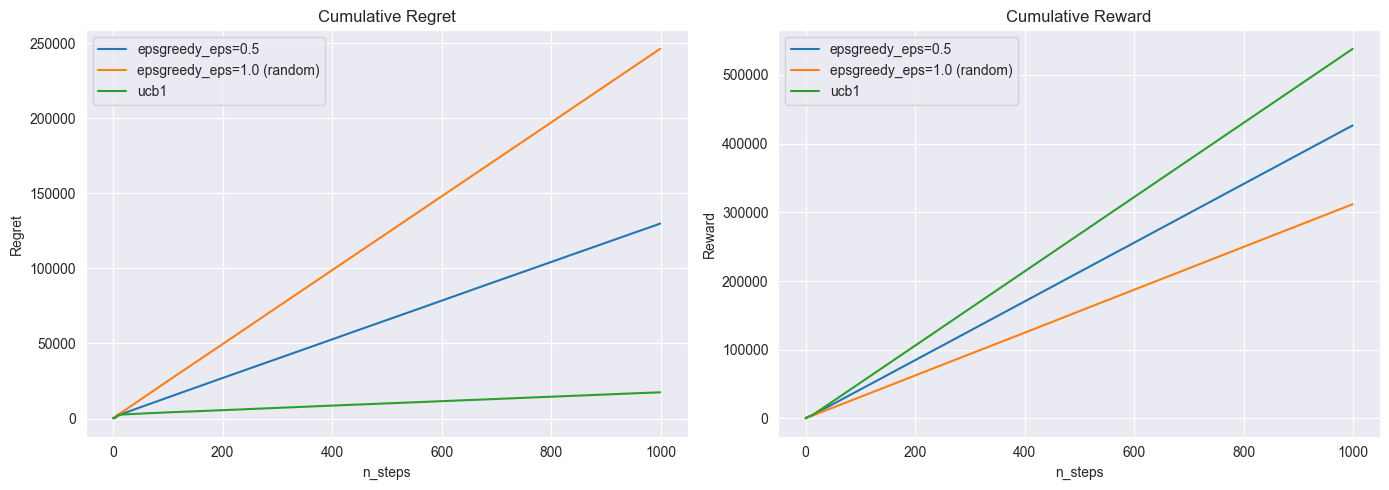

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
i = 0
for metric, metric_curves in curves.items():
    for strategy_type, metric_values in metric_curves.items():
        axes[i].plot(metric_values, label=strategy_type)
    axes[i].set_title(f'Cumulative {metric}')
    axes[i].set_xlabel('n_steps')
    axes[i].set_ylabel(metric)
    axes[i].legend()
    axes[i].grid(True)
    i += 1
    
plt.tight_layout()
plt.show()

<font color="red">Максимальный regret / минимальный reward там, где ручки = цены выбирались рандомно. Лучше всего показал себя подход UCB1. Мы просимулировали работу многоруких бандтов и проверили, что написанный нами код работает правильно. Теперь мы готовы выводить этот код в продакшен: когда мы это будем делать, нам уже не нужен будет PriceEnv, нашей средой будет настоящий мир и мы будем получать реально вознаграждение, а не симулированное.</font>

# Многорукие бандиты в качестве модели спроса

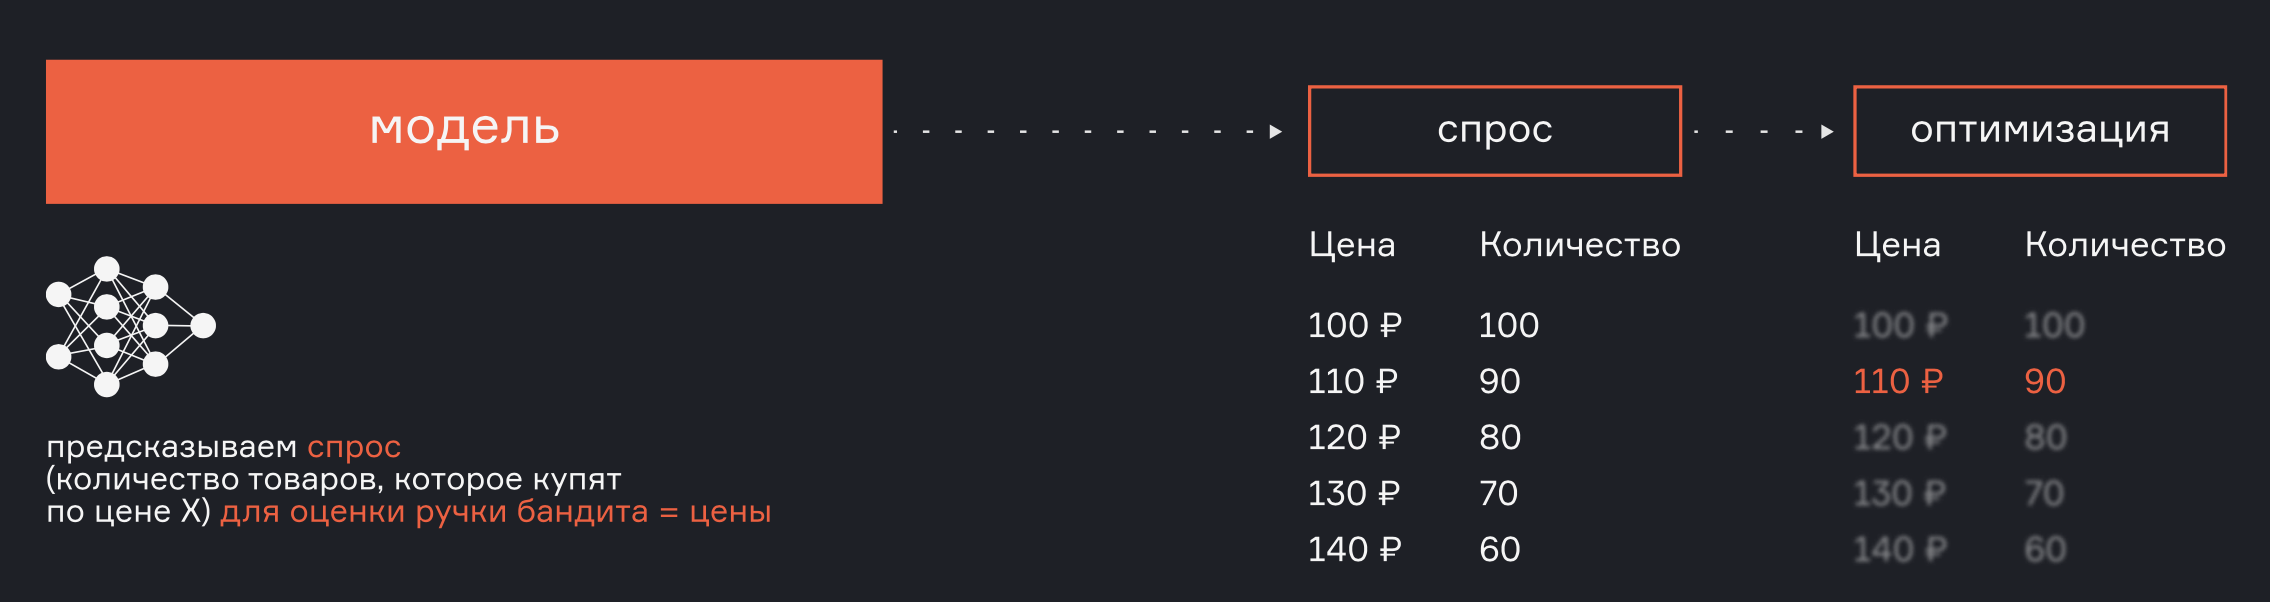

In [13]:
Image("./images/demand_approach.png", width=1000, height=400)

"Поменяем задачу - нам нужно сделать алгоритм динамического ценообразования на основе многоруких бандитов так, чтобы максимизировать выручку товара и не просадить маржу*:

<center>$Revenue \rightarrow \max, TestMargin \geq ControlMargin$</center>
<center>$Revenue = price * quantity$</center>
<center>$Margin = Revenue - cost * quantity$</center>

\* В реальности мы всегда ценообразуем пул товаров, но для простоты объяснения возьмем один товар для ценообразования.

2 задачи:
1. Exploration: находим кривую quantity / revenue / margin, цель - максимизировать quantity / revenue / margin соответственно
2. Exploitation: оптимизируем под нужды компании - можно воспользоваться методами из прошлых уроков (нахождение оптимальной цены при ограничениях через метод множителей Лагранжа)

## Exploration

In [ ]:
# 608762452 - ?
# 614562861 - 100

100 * 608762452 / 614562861 - 100

Нарисуем кривые для одной из стратегии, чтобы посмотреть, как строятся кривые quantity / revenue / margin и как часто бандит выбирает ту или иную ручку

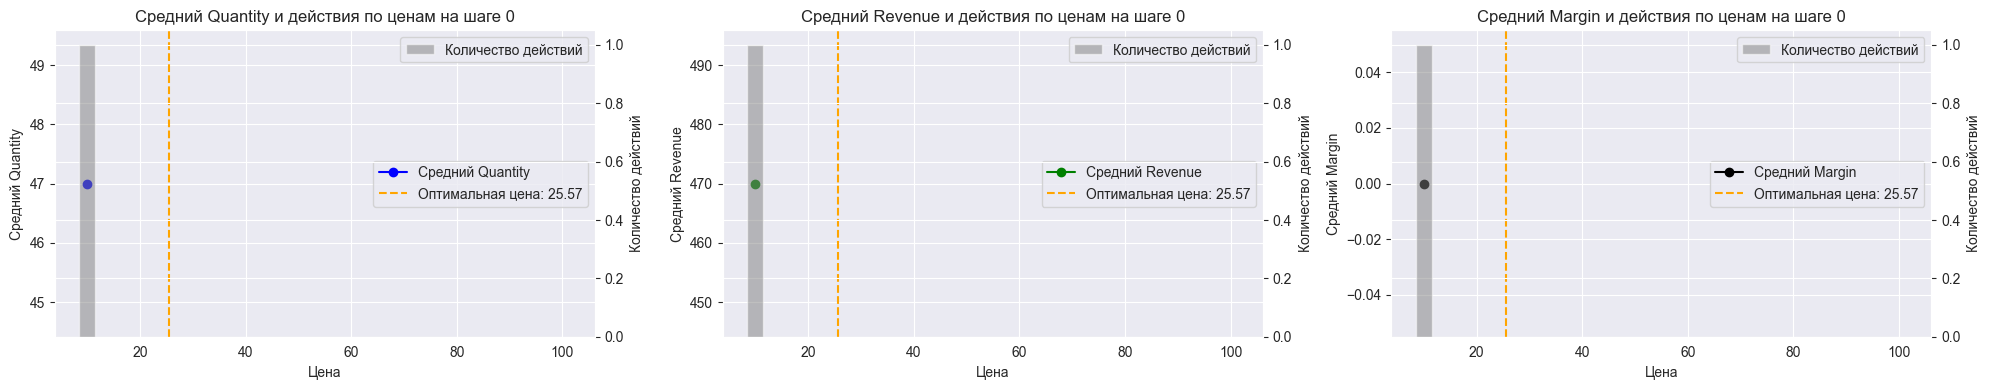

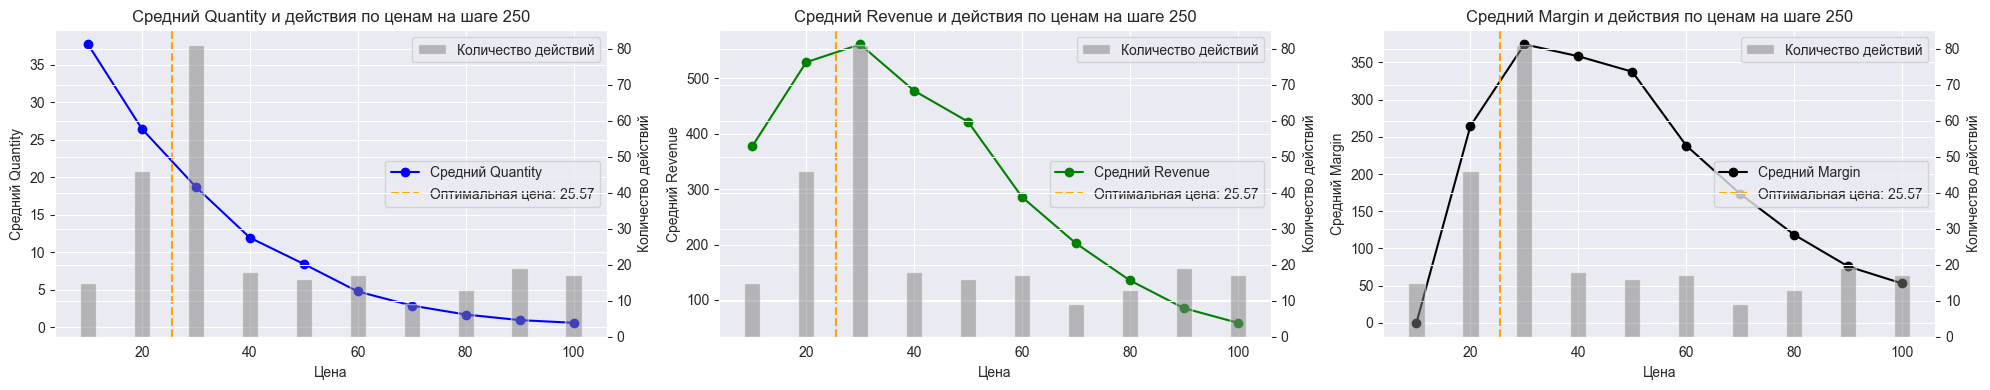

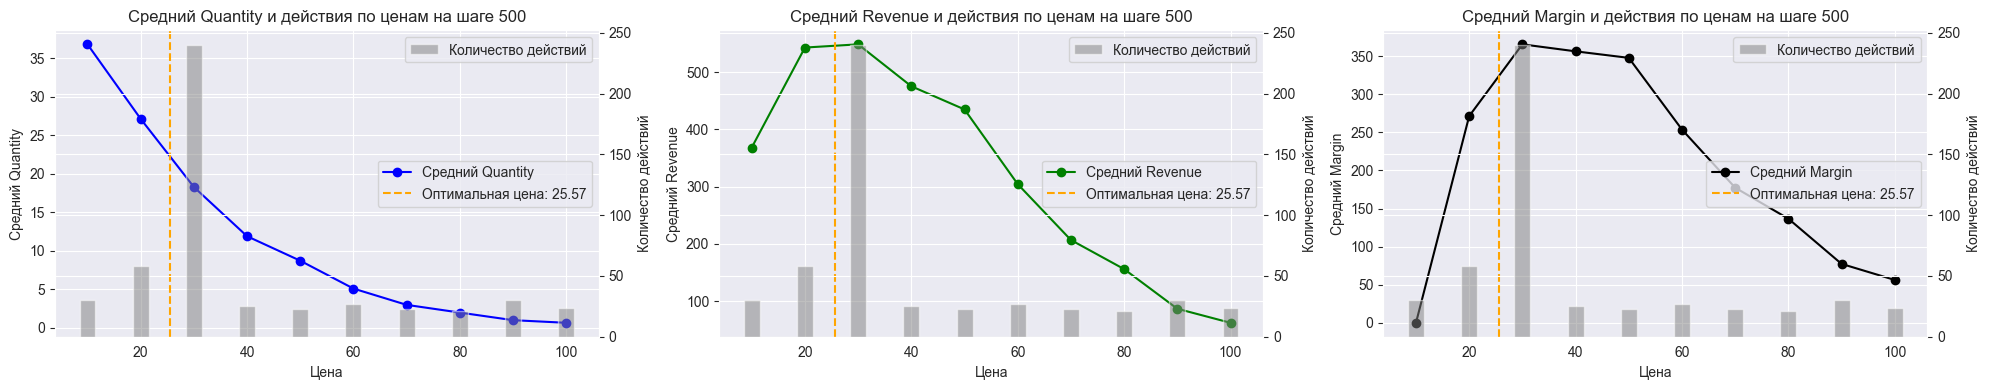

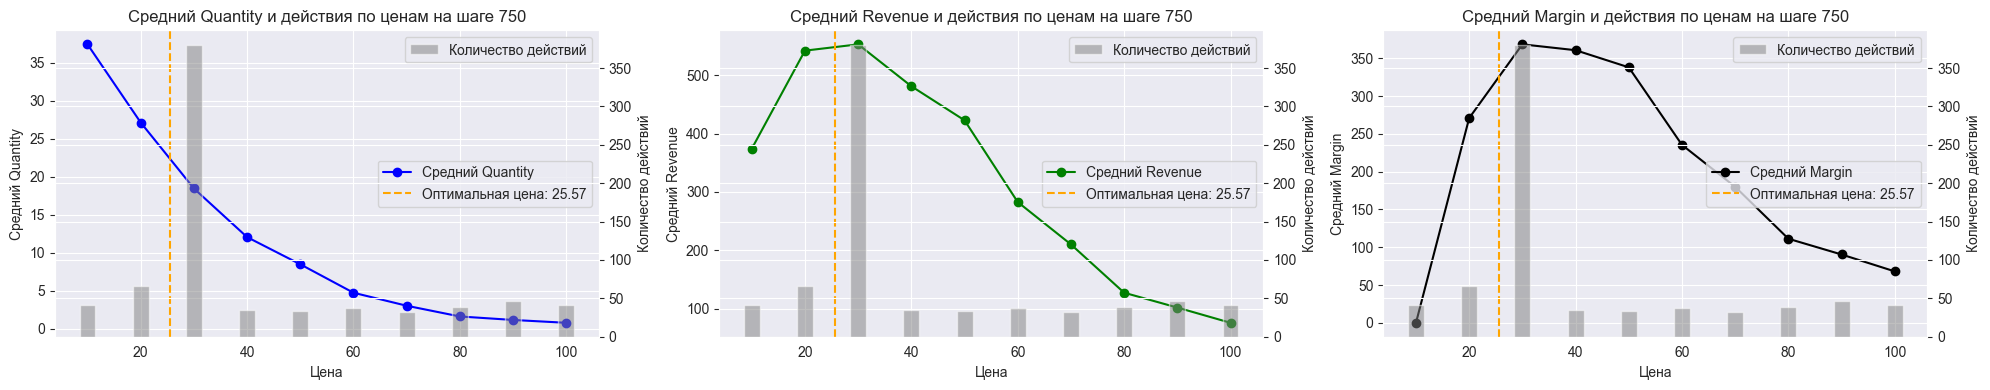

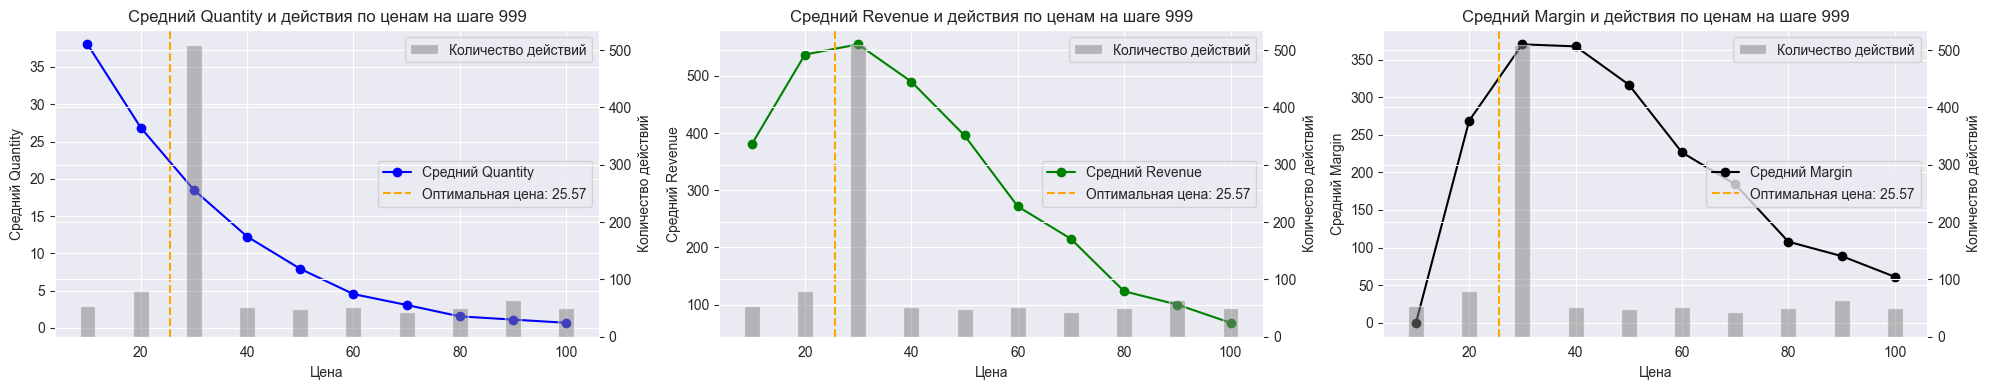

In [14]:
prices = np.arange(10, 110, 10).round(2).tolist()

cost = 10

base_demand, elasticity = 100, 0.05

env = PriceEnv(prices=prices,
               cost=cost,
               base_demand=base_demand,
               elasticity=elasticity)

n_steps = 1_000

strategy = EpsGreedy(n_arms=env.n_arms,
                     eps=0.5)

bandit = Bandit(env=env,
                strategy=strategy,
                target="revenue")

output_dict = bandit.run_simulation(
    n_steps=n_steps,
    do_plot_curves=True,
    plot_step=250,
)

<font color="red">Мы видим, что по мере поступления новой информации о каждой ручке, кривые  выглядят все ближе к реальности. Если мы уверены в кривых и хотим переходить к Exploitation, то мы можем использовать базовые методы оптимизации (например, метод множителей Лагранжа), которые были рассмотрены в предыдущих уроках. Если не уверены - нам требуется еще проводить exploration до тех пор, пока не будем уверены. Exploration можно периодически включать для выявления лучших оптимальных цен, так как среда, в которой мы работаем, постоянно меняется.</font>

#### Когда переходить к Exploitation?

- простая логика: N действий по каждой ручке
- распределение точек для каждой цены приближается к нормальному (можно воспользоваться критерием Колмогорова-Смирнова / Шапиро-Уилка)

    ЦПТ подразумевает, что если у вас достаточно большая выборка из генеральной совокупности, распределение средних этих выборок будет приближаться к нормальному распределению, даже если исходные данные не распределены нормально. Однако, в нашем случае далеко не всегда можно использовать ЦПТ, так как она требует отсутствия каких-то доминирующих распределений, а у нас могут бывать ситуации, отличные от нормальных, например, промо, праздники и тд - это стоит фильтровать при применении критериев.

Сейчас мы будем переходить от Exploration к Exploitation. Для этого нам нужно определиться с логикой остановки Exploration - остановимся, когда по каждой ручке будет не менее 20 наблюдений.

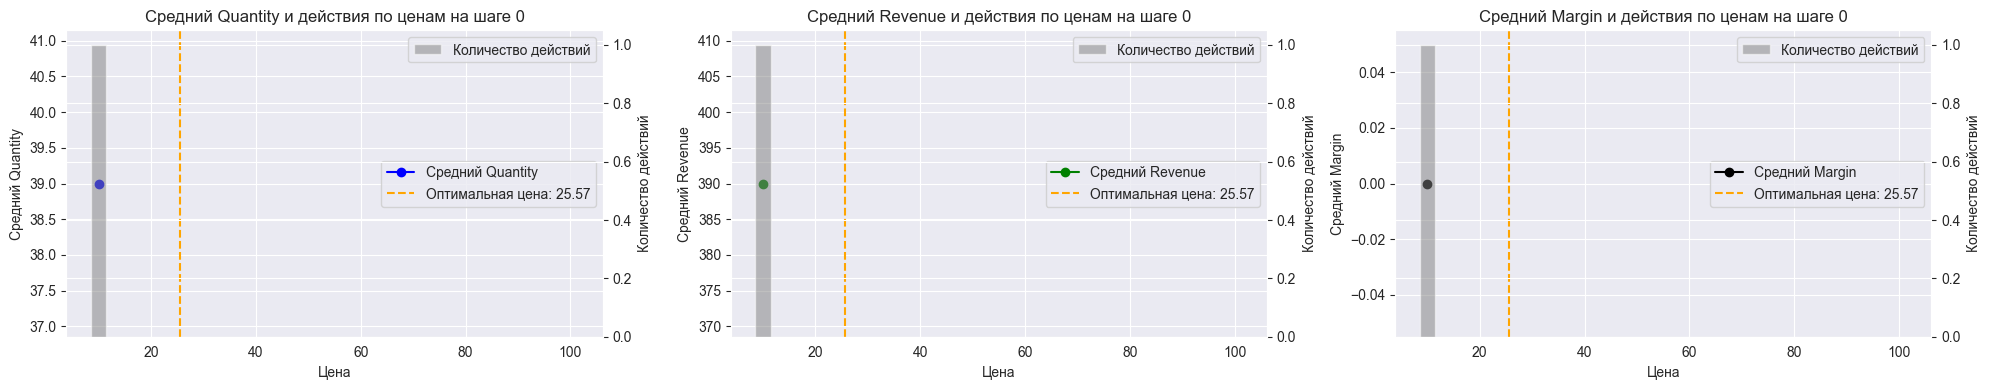

INFO:model:Early stopping at 560 step because the number of actions for each arm is greater than min_actions_num = 20


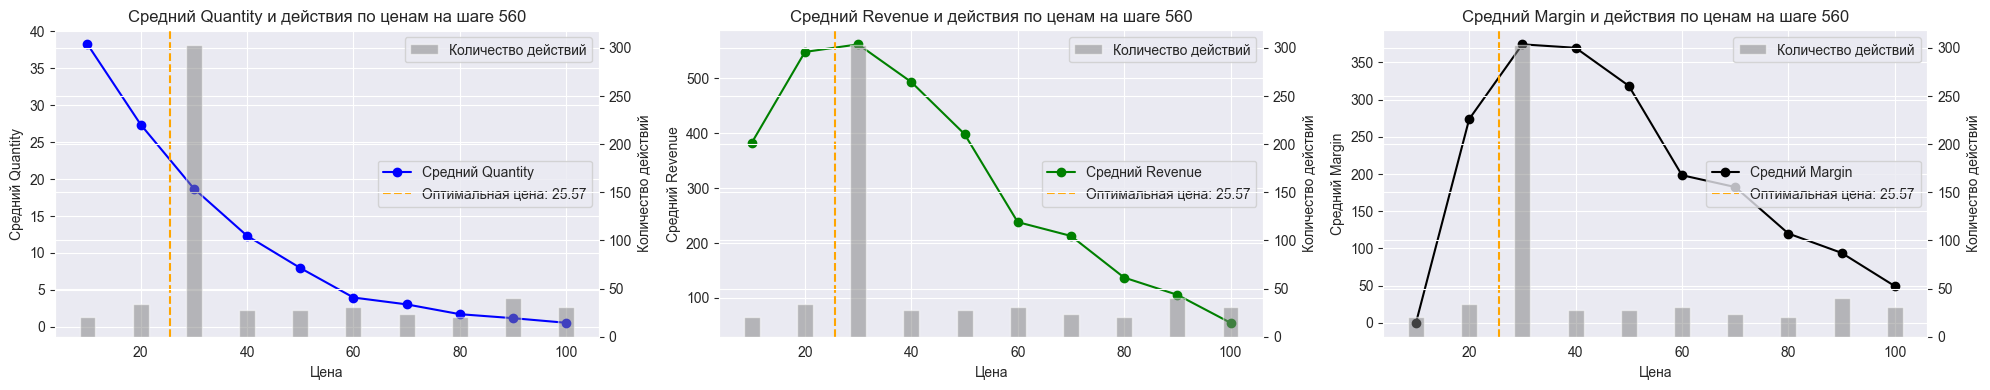

In [15]:
prices = np.arange(10, 110, 10).round(2).tolist()
cost = 10
base_demand, elasticity = 100, 0.05
env = PriceEnv(prices=prices, cost=cost, base_demand=base_demand, elasticity=elasticity)
n_steps = 1_000
strategy = EpsGreedy(n_arms=env.n_arms, eps=0.5)
bandit = Bandit(env=env, strategy=strategy, target="revenue")
output_dict = bandit.run_simulation(
    n_steps=n_steps,
    do_plot_curves=True,
    plot_step=1_000,
    do_stop_exploration=True,
    min_actions_num=20,
)

## Exploitation

In [16]:
# Создадим датасет для стадии оптимизации
df = pd.DataFrame({key: value for key, value in output_dict.items() if key in ["mean_quantity", "mean_revenue", "mean_margin"]})
df["price"] = prices
df["sku_id"] = "test"
df.head(20)

,mean_quantity,mean_revenue,mean_margin,price,sku_id
0,38.238095,382.380952,0.000000,10,test
1,27.382353,547.647059,273.823529,20,test
2,18.716172,561.485149,374.323432,30,test
3,12.321429,492.857143,369.642857,40,test
4,7.964286,398.214286,318.571429,50,test
5,3.967742,238.064516,198.387097,60,test
6,3.041667,212.916667,182.500000,70,test
7,1.714286,137.142857,120.000000,80,test
8,1.175000,105.750000,94.000000,90,test
9,0.548387,54.838710,49.354839,100,test


In [17]:
def log_uplifts(
    constraints: Dict[str, float],
    maximized_column: str,
    optimal_statistics: Dict[str, float],
) -> None:
    """
    Функция для логирования значений метрик и их аплифтов (улучшений).

    :param constraints: Словарь ограничений для метрик.
    :param maximized_column: Название столбца, который подлежит максимизации.
    :param optimal_statistics: Словарь с оптимальными статистическими данными.
    """
    # Логируем значение метрики, которую мы максимизируем
    logger.info(f"Metric: {maximized_column}", extra={"value": optimal_statistics.get(maximized_column)})

    # Проходим по всем метрикам и их ограничениям
    for metric, constraint in constraints.items():
        optimal_value = optimal_statistics.get(metric)
        if optimal_value is None:
            raise ValueError(f"`{metric}` has not been counted")
        # Логируем информацию по каждой метрике, включая аплифты
        log_dict = {
            "constraint value": round(constraint, 3),
            "optimal value": round(optimal_value, 3),
            "uplift (abs)": round(optimal_value - constraint, 3),
            "uplift (pct)": round(optimal_value * 100 / constraint - 100, 3),
        }
        logger.info(f"Metric: {metric}")
        for key, value in log_dict.items():
            logger.info(f"{key}= {value}")


def apply_constraints(
    df: pd.DataFrame,
    constraints: Dict[str, float],
) -> pd.DataFrame:
    """
    Фильтруем датасет по заданным ограничениям.

    :param df: DataFrame с данными для фильтрации.
    :param constraints: Словарь ограничений для каждой метрики.
    :return: Отфильтрованный DataFrame.
    """
    # Применяем ограничения к датафрейму, фильтруя строки
    for metric, constraint in constraints.items():
        df = df[df[metric] >= constraint]
    return df


def calculate_cum_lambda_metrics(
    df: pd.DataFrame,
    agg_columns: List[str],
    maximized_column: str,
) -> pd.DataFrame:
    """
    Считаем агрегированные значения метрик для каждой комбинации лямбда-значений.

    :param df: DataFrame с данными.
    :param agg_columns: Список столбцов для агрегации.
    :param maximized_column: Столбец, который максимизируется.
    :return: Агрегированный DataFrame.
    """
    # Группируем данные по комбинации лямбда-значений и агрегируем указанные столбцы
    df = df.groupby("lambda_combination").agg({column: "sum" for column in agg_columns})
    df = df.reset_index()
    return df


def choose_optimal_values(
    metric_lambda_map: Dict[str, float],
    df: pd.DataFrame,
    levels: List[str],
    price_column: str,
    maximized_column: str,
) -> pd.DataFrame:
    """
    Находим оптимальные цены / наценки для каждого уровня для lambda_value
    """
    # Считаем лагранжианы при lambda_value
    df["lagrangian"] = df[maximized_column]
    lambda_combination_name = ""
    for metric, metric_lambda in metric_lambda_map.items():
        df["lagrangian"] += df[metric] * metric_lambda
        lambda_combination_name += f"{metric}={metric_lambda}_"
    # Находим максимальный лагранжиан для каждого уровня
    optimal_df = df.groupby(levels).agg({"lagrangian": "max"})
    df = df.merge(optimal_df, on=levels + ["lagrangian"], how="inner")
    # Добавляем колонку с lambda_value для запоминания
    df["lambda_combination"] = lambda_combination_name.strip("_")
    # Удаляем дубликаты (например, оставляем минимальные цены / наценки из оптимальных),
    # так как возможны одни и те же значения метрик для разных цен / наценок
    # => одинаковые лагранжианы, а нам нужно выбрать одно значение для каждого уровня
    df = df.sort_values(price_column)
    df = df.drop_duplicates(subset=levels)
    return df


def get_metric_lambda_maps(lambda_config: Dict[str, Any]) -> List[Dict[str, float]]:
    # Получаем список значений для каждого ключа
    lambda_lists = list(lambda_config.values())
    # Используем meshgrid для генерации всех комбинаций параметров
    lambda_mesh = np.meshgrid(*lambda_lists)
    # Преобразование в массив и решейпинг
    lambda_vars = np.stack(lambda_mesh, axis=-1).reshape(-1, len(lambda_config))
    # Создаем список словарей
    metric_lambda_maps = [
        dict(zip(lambda_config.keys(), combination)) for combination in lambda_vars
    ]
    return metric_lambda_maps


def calculate_lagrangians(
    df: pd.DataFrame,
    lambda_config: Dict[str, Any],
    levels: List[str],
    price_column: str,
    maximized_column: str,
) -> pd.DataFrame:
    """
    Для каждого значения lambda находим оптимальные цены / наценки для каждого уровня
    """
    lambda_dfs = []
    metric_lambda_maps = get_metric_lambda_maps(lambda_config=lambda_config)
    logger.info(
        f"Start calculating lagrangians, {len(metric_lambda_maps)} lambda combinations"
    )
    for metric_lambda_map in metric_lambda_maps:
        lambda_df = choose_optimal_values(
            metric_lambda_map=metric_lambda_map,
            df=df,
            levels=levels,
            price_column=price_column,
            maximized_column=maximized_column,
        )
        lambda_dfs.append(lambda_df)
    df = pd.concat(lambda_dfs)
    df = df.reset_index(drop=True)
    logger.info(f"Ended calculating lagrangians")
    return df


# Общая функция для оптимизации
def optimize(
    df: pd.DataFrame,
    lambda_config: Dict[str, Any],
    maximized_column: str,
    constraints: Dict[str, float],
    levels: List[str],
    price_column: str,
) -> pd.DataFrame:
    logger.info("Start choosing optimal prices")
    lambda_df = calculate_lagrangians(
        df=df,
        lambda_config=lambda_config,
        levels=levels,
        price_column=price_column,
        maximized_column=maximized_column,
    )
    statistics_df = calculate_cum_lambda_metrics(
        df=lambda_df,
        agg_columns=[maximized_column] + list(constraints.keys()),
        maximized_column=maximized_column,
    )
    statistics_df = statistics_df.sort_values(maximized_column, ascending=False)
    logger.info(f"\n{statistics_df.head()}")
    statistics_df = apply_constraints(df=statistics_df, constraints=constraints)
    logger.info(f"\n{statistics_df.head()}")
    best_lambda = statistics_df["lambda_combination"].tolist()[0]
    optimal_statistics = statistics_df[
        statistics_df["lambda_combination"] == best_lambda
    ].to_dict(orient="records")[0]
    optimal_df = lambda_df[lambda_df["lambda_combination"] == best_lambda]
    log_uplifts(
        constraints=constraints,
        maximized_column=maximized_column,
        optimal_statistics=optimal_statistics,
    )
    logger.info("Ended choosing optimal prices")
    return optimal_df

In [18]:
# Считаем ограничения
control_mean_margin = df[df["price"] == 10]["mean_margin"].sum()
optimal_df = optimize(
    df=df,
    # перебираем разные lambda для маржи
    lambda_config={
        "mean_margin": np.arange(0.0, 0.0001, 0.0000001).round(7).tolist(),
    },
    # указываем, что хотим максимизировать
    maximized_column="mean_revenue",
    # указываем ограничения
    constraints={
        "mean_margin": control_mean_margin,
    },
    levels=["sku_id"],
    price_column="price",
)
optimal_df.head()

INFO:model:Start choosing optimal prices
INFO:model:Start calculating lagrangians, 1001 lambda combinations
INFO:model:Ended calculating lagrangians
INFO:model:
       lambda_combination  mean_revenue  mean_margin
0         mean_margin=0.0    561.485149   374.323432
672  mean_margin=7.05e-05    561.485149   374.323432
659  mean_margin=6.96e-05    561.485149   374.323432
660  mean_margin=6.97e-05    561.485149   374.323432
661  mean_margin=6.98e-05    561.485149   374.323432
INFO:model:
       lambda_combination  mean_revenue  mean_margin
0         mean_margin=0.0    561.485149   374.323432
672  mean_margin=7.05e-05    561.485149   374.323432
659  mean_margin=6.96e-05    561.485149   374.323432
660  mean_margin=6.97e-05    561.485149   374.323432
661  mean_margin=6.98e-05    561.485149   374.323432
INFO:model:Metric: mean_revenue
INFO:model:Metric: mean_margin
INFO:model:constraint value= 0.0
INFO:model:optimal value= 374.323
INFO:model:uplift (abs)= 374.323
INFO:model:uplift (pct)= inf

,mean_quantity,mean_revenue,mean_margin,price,sku_id,lagrangian,lambda_combination
0,18.716172,561.485149,374.323432,30,test,561.485149,mean_margin=0.0


<font color="red">
Итак, мы нашли оптимальную цену для товара по условиям нашей задачи. Здесь стоит помнить, что мы сейчас прошли все этапы для одного товара. В реальности же мы работаем с пулом товаров. Самый простой способ - иметь бандита на каждый товар и использовать изученный нами код в цикле.
</font>

После того, как мы провели симуляцию и проверили, что наш код работает исправно (например, строятся адекватные графики, написаны юнит-тесты, запустили BackTest), переходим к использованию многоруких бандитов в реальной среде. С помощью симуляции мы также подобрали параметры, которые нужны для запуска бандита (n_iter, параметры стратегии).

# Резюме

- многорукие бандиты можно использовать для разных целей:
    - для простой оптимизации, где оптимизируется одна метрика без ограничений
    - для построения модели спроса = exploration'a и совмещать это с методами оптимизации, которые учитывают ограничения
- перед выведением многоруких бандитов в продакшен следует проводить симуляцию на искусственно созданных данных
- UCB стратегии лучше, чем ε-greedy стратегии